In [1]:
import xarray
import numpy as np
import pandas
from matplotlib import pyplot as plt
import os
import proplot
import gsw as TEOS_10

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]


In [2]:
def CSIRO_standard_levels():
    
    depth_levels  = np.asarray([2,5,10,20,30,40,50,60,70,75,80,90,100,110,120,125,130,140,150,160,170,175,180,190,200,
                                   210,220,225,230,240,250,260,270,275,280,290,300,325,350,375,400,425,450,475,500,550,600,
                                   650,700,750,800,850,900,950,1000,1100,1200,1300,1400,1500,1600,1700,1750,1800,1900,2000,
                                   2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000,5500,6000])
    
    return depth_levels

In [82]:
import gsw

def gsw_tracer_interp(tracer, p, p_i, scale_factor=0.33):
    """
    Interpolates vertical casts of values of tracer data to arbitrary pressures p_i.
    
    Parameters:
        tracer (ndarray): Tracer values [M, N]
        p (ndarray): Sea pressure [M, N] or [M, 1] or [1, N]
        p_i (ndarray): Specific query points at which the interpolated tracer values are required [M_i, N] or [M_i, 1]
        scale_factor (float): Scaling factor of the maximum magnitude of the slope on the [tracer - bottle_number] diagram. Default is 0.33.
    
    Returns:
        ndarray: Interpolated tracer values at pressures p_i [M_i, N]
    """
    
    # Check variables and resize if necessary
    pl, number_of_profiles = tracer.shape
    mp, n_pressure = p.shape
    interp_profile_length, np_i = p_i.shape
    #print(np_i)
    #print(interp_profile_length,np_i)
    if pl < 4 and np == 1:
        raise ValueError('There must be at least 4 bottles')
    elif number_of_profiles == n_pressure and mp == 1:
        p = np.tile(p, (pl, 1))
    elif pl == mp and n_pressure == 1:
        p = np.tile(p, (1, number_of_profiles))
    elif number_of_profiles == mp and n_pressure == 1:
        p = p.T
        p = np.tile(p, (pl, 1))
    elif pl == n_pressure and mp == 1:
        p = p.T
        p = np.tile(p, (1, number_of_profiles))
    elif pl == np and number_of_profiles == mp:
        p = p.T
    elif pl == mp and number_of_profiles == n_pressure:
        pass
    else:
        raise ValueError('Inputs array dimensions arguments do not agree')
    
    #print(interp_profile_length)
    #print(np.diff(p_i,axis=0))
    #print('==================')
    
    if interp_profile_length == 1 and np_i > 1:
        p_i = p_i.T
        dp_i = np.diff(p_i, axis=0)
        if np.any(dp_i < 0):
            raise ValueError('Interpolating pressure must be monotonic')
        interp_profile_length, np_i = p_i.shape
    elif interp_profile_length == number_of_profiles and np_i != number_of_profiles and np.all(np.diff(p_i, axis=1) >= 0):
        p_i = p_i.T
        interp_profile_length, np_i = p_i.shape
        
    elif np.any(np.diff(p_i, axis=0) < 0):
        raise ValueError('Interpolating pressure must be monotonic')
    else:
        # Data shape and interval are ok.
        pass

    if not isinstance(scale_factor, (int, float)):
        raise ValueError('scale_factor must be a scalar')

    # Start of the calculation
    tracer_i = np.full((interp_profile_length, number_of_profiles), np.nan)
    for Iprofile in range(number_of_profiles):
        
        data_bottles = tracer[:, Iprofile] + p[:, Iprofile]
        Inn = np.where(~np.isnan(data_bottles))[0]
        if len(Inn) < 2:
            tracer_i[:, Iprofile] = np.nan
            continue
        
        tracer_obs = tracer[Inn, Iprofile]
        p_obs = p[Inn, Iprofile]

        if np_i != 1:
            p_i_tmp = p_i[:, Iprofile]
        else:
            p_i_tmp = p_i
        #print(p_i_tmp.shape)        #pchip_interp(pressure_obs,data_obs,pressure_levels_interp )
        #print(p_obs.shape)
        #print(tracer_obs.shape)
        #blah = gsw.pchip_interp(p_obs, tracer_obs, p_i_tmp.squeeze())
        
        #print(blah.shape)
        
        
        try:
            tracer_i[:, Iprofile] = gsw.pchip_interp(p_obs, tracer_obs, p_i_tmp.squeeze() )
        except:
            tracer_i[:, Iprofile] = np.nan
            print('Bad profile to interpolate: ', Iprofile)
            #print(p_i_tmp.squeeze())
            #plt.plot(tracer_obs,-p_obs)
            
            
            #dsada
            
            

        
        max_p_obs = np.nanmax(p_obs)
        i_end_of_profile = np.nonzero(p_i_tmp>max_p_obs)[0]
        tracer_i[i_end_of_profile, Iprofile] = np.nan
        
    return tracer_i


In [108]:
CODA_path = '/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/CODAv1'

START_YEAR = 2018
END_YEAR   = 2023


NORTH_LAT_LIM = 0
SOUTH_LAT_LIM = -50

WEST_LON_LIM = 90
EAST_LON_LIM = 180

DATA_SOURCE  = ['RAN','MNF','WOD2018','AIMS']
#DATA_SOURCE  = ['AIMS']

OBS_PLATFORM = ['ctd','pfl','xbt','mrb','osd']
#OBS_PLATFORM = ['pfl']

DATA_VARIABLES = ['Temperature'] #,'Salinity','Oxygen','Nitrate']
#DATA_VARIABLES = ['Salinity']interpolate


In [109]:
profile_dataset

<xarray.Dataset>
Dimensions:                 (cast: 175912, z_index: 3294)
Coordinates:
  * cast                    (cast) int64 1 2 3 4 ... 175909 175910 175911 175912
    time                    (cast) datetime64[ns] ...
    lat                     (cast) float32 ...
    lon                     (cast) float32 ...
  * z_index                 (z_index) int64 0 1 2 3 4 ... 3290 3291 3292 3293
    z                       (cast, z_index) float32 ...
Data variables: (12/33)
    WOD_id                  (cast) int32 ...
    origflagset             (cast) |S100 ...
    country                 (cast) |S100 ...
    dataset                 (cast) |S100 ...
    Access_no               (cast) float64 ...
    dbase_orig              (cast) |S100 ...
    ...                      ...
    pH_WODflag              (cast, z_index) float64 ...
    pH_origflag             (cast, z_index) float32 ...
    z_WODflag               (cast, z_index) float64 ...
    z_origflag              (cast, z_index) float32 ...
    crs                     int32 ...
    CODA_id                 (cast) |S20 ...
Attributes:
    Parent ragged array file:  wod_pfl_2018.nc

In [111]:
pressure_levels = CSIRO_standard_levels()
output_path = '/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/CODA_interp_aus_region'

for i_var in DATA_VARIABLES:
    for i_year in range(START_YEAR,END_YEAR+1):
        for i_platform in OBS_PLATFORM:
            
            
            for i_source in  DATA_SOURCE:
                
                file_to_get = i_source + '_CODA_' + str(i_year) + '_' + i_platform + '.nc'  #WOD_CODA_2010_pfl_test_all_vars.nc
                if os.path.isfile(os.path.join(CODA_path,str(i_year),file_to_get)):
                    
                    profile_dataset  = xarray.open_dataset(os.path.join(CODA_path,str(i_year),file_to_get),mask_and_scale=True)
                    print('Working on file: ', file_to_get)

                    if i_var in profile_dataset.data_vars:
                    
                        variable_casts  = profile_dataset[i_var]
                        idx_casts_with_data = np.nonzero(np.logical_not(np.all(np.isnan(variable_casts),axis=1)).values)[0]
                        
                        profile_dataset_with_data = profile_dataset.isel(cast=idx_casts_with_data)
                                                
                        
                        
                        lat_points = profile_dataset_with_data['lat'].values
                        lon_points = profile_dataset_with_data['lon'].values
                        
                        idx_in_lat_lon_lims = np.nonzero(np.logical_and(
                                                np.logical_and(lat_points>=SOUTH_LAT_LIM,lat_points<=NORTH_LAT_LIM ) ,
                                                np.logical_and(lon_points>=WEST_LON_LIM,lon_points<=EAST_LON_LIM ) ) )[0]
                        
                        profile_dataset_with_data_in_lims = profile_dataset_with_data.isel(cast=idx_in_lat_lon_lims)
                        n_casts,n_profile_index           = profile_dataset_with_data_in_lims[i_var].shape

                        if n_casts != 0:
                            
                        
                            lat_points_in_lat_lon_lims     = profile_dataset_with_data_in_lims['lat']
                            lon_points_in_lat_lon_lims     = profile_dataset_with_data_in_lims['lon']
                            time_points_in_lat_lon_lims    = profile_dataset_with_data_in_lims['time']
                            CODA_id_points_in_lat_lon_lims = profile_dataset_with_data_in_lims['CODA_id']
                        


                            z         = profile_dataset_with_data_in_lims['z']
                            data_vars = profile_dataset_with_data_in_lims[i_var]
                        
                        
                            if i_var + '_WODflag' in profile_dataset.data_vars:
                                data_QC   = profile_dataset_with_data_in_lims[i_var + '_WODflag']
                                z_QC   = profile_dataset_with_data_in_lims['z_WODflag']

                            elif  i_var + '_origflag' in profile_dataset.data_vars:
                                data_QC   = profile_dataset_with_data_in_lims[i_var + '_origflag']
                            else:
                                data_QC = xarray.zeros_like(data_vars)
                            
                        
                            if i_source == 'WOD':
                                data_vars = data_vars.where(data_QC == 0)
                                z = z.where(z_QC == 0)
                            elif i_source == 'MNF':
                                data_vars = data_vars.where( np.logical_or(np.logical_or (data_QC == 0, data_QC == 1), data_QC == 2) )
                            
                            elif i_source =='RAN':
                                data_vars = data_vars.where( np.logical_or(np.logical_or (data_QC == 0, data_QC == 1), data_QC == 2))
                        
                            #"Z" is defined as per TEOS 10, being negative if below the sea surface
                            #Convert the z profile to negative values if required,
                            #The remove any values that are positive (ie. higher than the sea surface )

                            avg_z = z.mean(dim='z_index')
                            z = z.where(avg_z<0,-1*z)
                            z = z.where(z<0)
                    
                           
                            #Convert from -depth to to pressure 
                            pressure_obs = TEOS_10.p_from_z(z.values.T,lat_points_in_lat_lon_lims.values)
                            data_var_interp = gsw_tracer_interp(data_vars.values.T, pressure_obs, np.tile(pressure_levels,[1,1]).T, scale_factor=0.33)
                        
                        
                            data_var_interp = data_var_interp.T
                        
                            interp_var_dataarray = xarray.DataArray(data_var_interp,dims=['cast','pressure'],
                                                                coords={'cast':profile_dataset_with_data_in_lims['cast'],
                                                                       'pressure':pressure_levels})
                        
                        
                            interp_var_dataarray = interp_var_dataarray.to_dataset(name=i_var)
                        
                        
                        
                            interp_var_dataarray['lat']     = xarray.DataArray(lat_points_in_lat_lon_lims,dims=['cast'],
                                                                coords={'cast':profile_dataset_with_data_in_lims['cast']})
                            interp_var_dataarray['lon']     = xarray.DataArray(lon_points_in_lat_lon_lims,dims=['cast'],
                                                                coords={'cast':profile_dataset_with_data_in_lims['cast']})
                        
                            interp_var_dataarray['time']    = xarray.DataArray(time_points_in_lat_lon_lims,dims=['cast'],
                                                                coords={'cast':profile_dataset_with_data_in_lims['cast']})
                            interp_var_dataarray['CODA_id'] = xarray.DataArray(CODA_id_points_in_lat_lon_lims,dims=['cast'],
                                                                coords={'cast':profile_dataset_with_data_in_lims['cast']})
                        
                            output_file_name =  i_source + '_CODA_' + str(i_year) + '_' + i_platform + '_' + i_var + '.Aus_region.interp.nc'
                            print('Writing to file: ', output_file_name)                            
                            interp_var_dataarray.to_netcdf(os.path.join(output_path,output_file_name))
                    
                        else:
                            print('No casts in region for variable: ', i_var, " with platform: ", i_platform)
                        #END if n_casts==0
                    #END for i_var
                    
                #END if file exists
                
            #END for i_source
            
        #END for i_platform
    #END for i_year
#END for i_var

Working on file:  MNF_CODA_2018_ctd.nc
1
80 1
Writing to file:  MNF_CODA_2018_ctd_Temperature.Aus_region.interp.nc
Working on file:  WOD2018_CODA_2018_ctd.nc
1
80 1
Writing to file:  WOD2018_CODA_2018_ctd_Temperature.Aus_region.interp.nc
Working on file:  AIMS_CODA_2018_ctd.nc
1
80 1
Writing to file:  AIMS_CODA_2018_ctd_Temperature.Aus_region.interp.nc
Working on file:  WOD2018_CODA_2018_pfl.nc
1
80 1
Writing to file:  WOD2018_CODA_2018_pfl_Temperature.Aus_region.interp.nc
Working on file:  WOD2018_CODA_2018_xbt.nc
1
80 1
Writing to file:  WOD2018_CODA_2018_xbt_Temperature.Aus_region.interp.nc
Working on file:  WOD2018_CODA_2018_mrb.nc
1
80 1
Writing to file:  WOD2018_CODA_2018_mrb_Temperature.Aus_region.interp.nc
Working on file:  WOD2018_CODA_2018_osd.nc
1
80 1
Writing to file:  WOD2018_CODA_2018_osd_Temperature.Aus_region.interp.nc
Working on file:  MNF_CODA_2019_ctd.nc
1
80 1
Writing to file:  MNF_CODA_2019_ctd_Temperature.Aus_region.interp.nc
Working on file:  WOD2018_CODA_2019_ct

In [127]:
#output_file_name =  i_source + '_CODA_' + str(2022) + '_' + 'pfl' + '_' + i_var + '.Aus_region.interp.nc'
output_file_name =  'MNF_CODA_' + str(2015) + '_' + 'ctd' + '_' + i_var + '.Aus_region.interp.nc'

print('Writing to file: ', output_file_name)                            
interp_var_dataarray = xarray.open_dataset(os.path.join(output_path,output_file_name))

Writing to file:  MNF_CODA_2015_ctd_Temperature.Aus_region.interp.nc


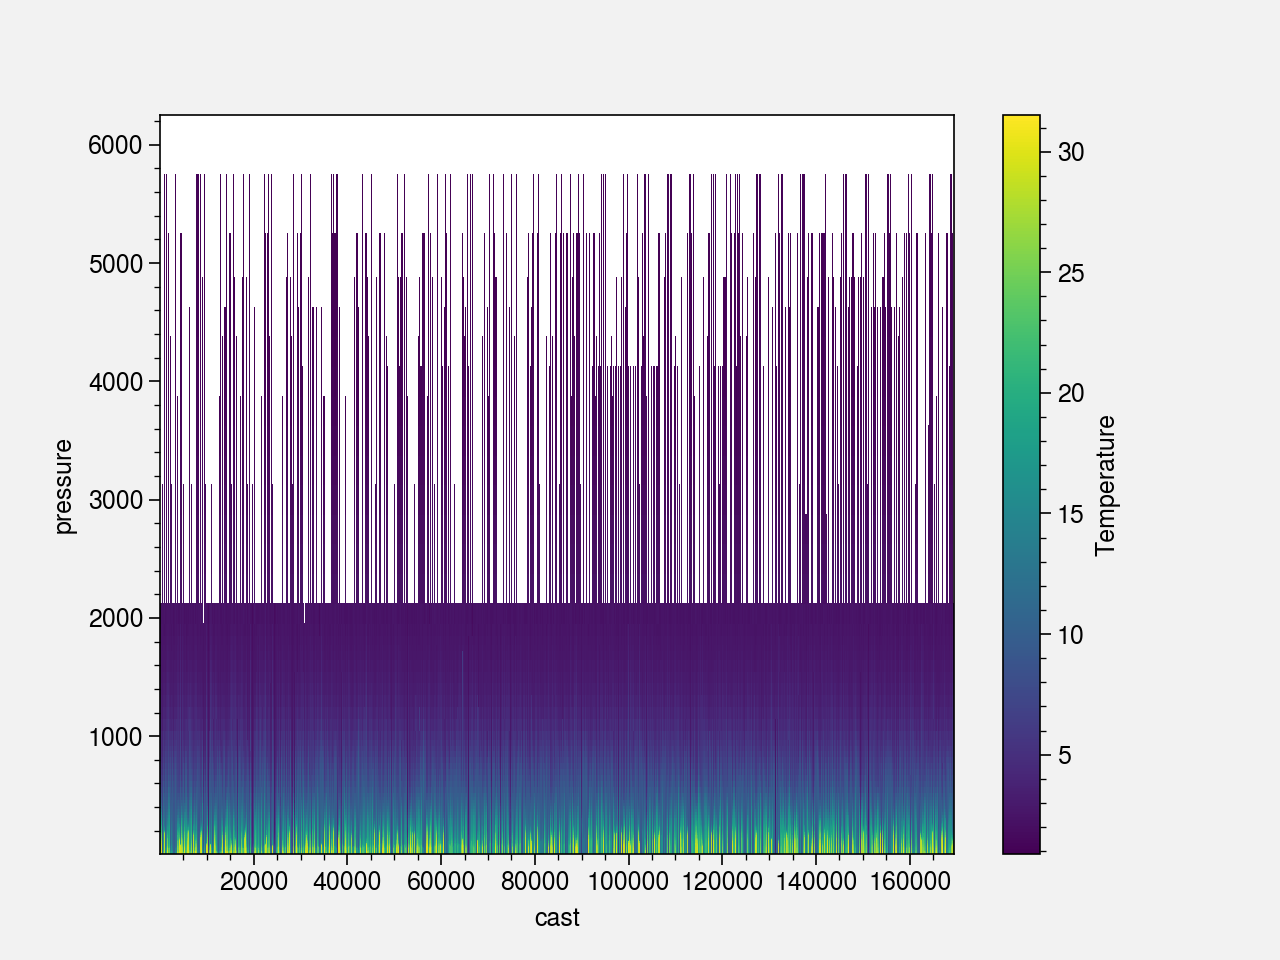

In [118]:
interp_var_dataarray['Temperature'].T.plot()

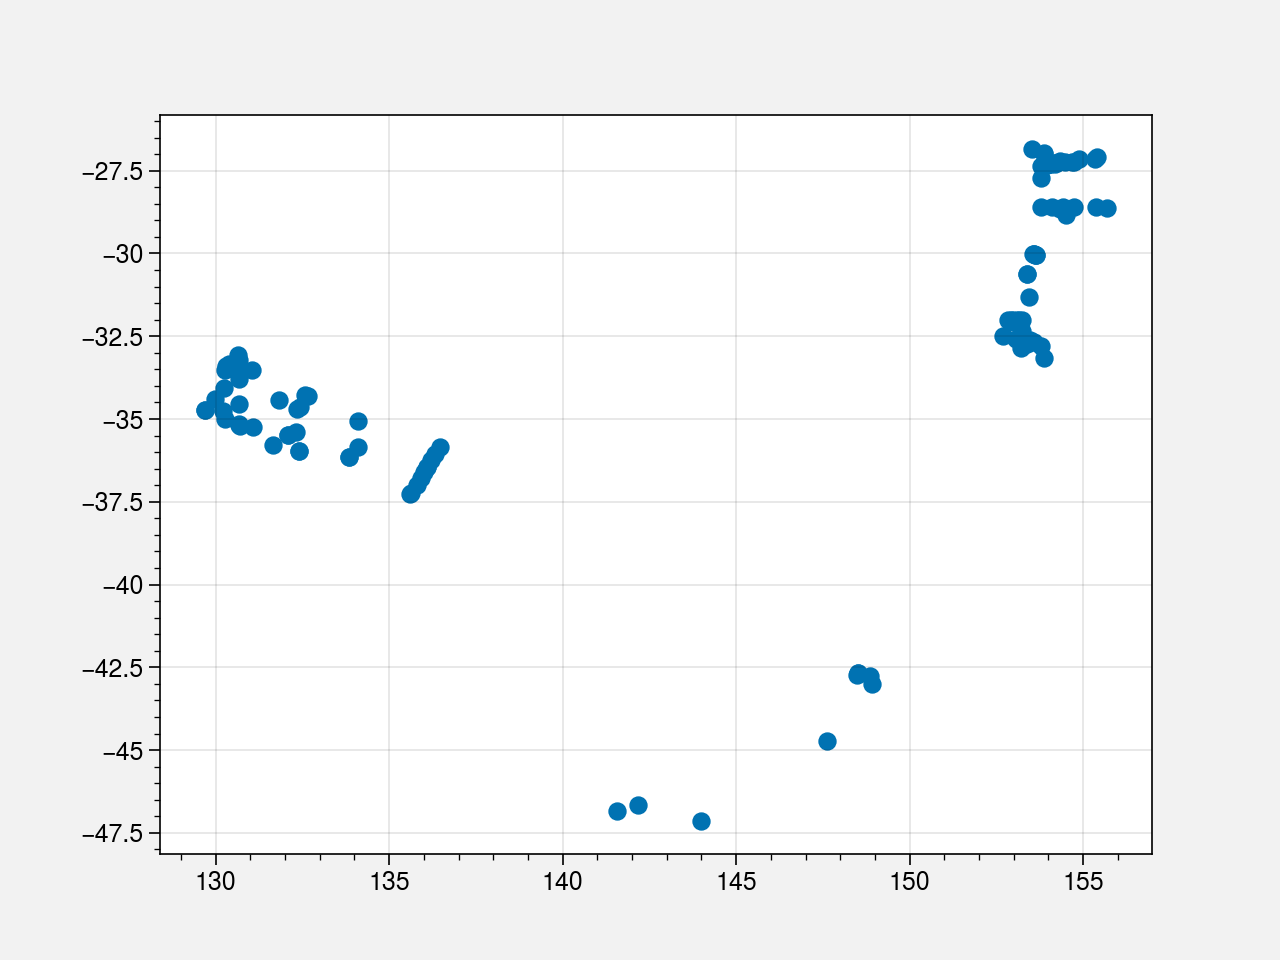

In [128]:
plt.scatter(interp_var_dataarray['lon'],interp_var_dataarray['lat'])


In [88]:
data_vars

ValueError: zero-size array to reduction operation minimum which has no identity

<xarray.DataArray 'Temperature' (cast: 0, z_index: 37)>
array([], shape=(0, 37), dtype=float32)
Coordinates:
  * cast     (cast) int64 
    time     (cast) datetime64[ns] ...
    lat      (cast) float32 
    lon      (cast) float32 
  * z_index  (z_index) int64 0 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
    z        (cast, z_index) float32 ...
Attributes:
    long_name:            sea_water_temperature
    standard_name:        sea_water_temperature
    units:                degree_C
    grid_mapping:         crs
    ancillary_variables:  Temperature_sigfigs Temperature_WODflag Temperature...

In [60]:
i_cast = 3404
gsw.pchip_interp(pressure_obs[:,i_cast].T, data_vars[i_cast,:], pressure_levels )

RuntimeError: gsw_util_pchip_interp failed; check input arguments

In [76]:
idx_wrong_sign

NameError: name 'idx_wrong_sign' is not defined

In [79]:
z

<xarray.DataArray 'z' (cast: 11337, z_index: 1049)>
array([[ -4.562876 , -11.307812 , -19.14356  , ...,         nan,
                nan,         nan],
       [ -1.9885432,  -7.9540563, -12.925184 , ...,         nan,
                nan,         nan],
       [ -4.270292 ,  -8.838411 , -18.768755 , ...,         nan,
                nan,         nan],
       ...,
       [ -5.4576244,  -8.930583 , -14.884088 , ...,         nan,
                nan,         nan],
       [ -5.46412  ,  -8.941212 , -14.901802 , ...,         nan,
                nan,         nan],
       [ -4.561496 ,  -9.420368 , -14.378282 , ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * cast     (cast) int64 41 52 59 71 95 ... 113580 113589 113590 113602 113610
    time     (cast) datetime64[ns] 2008-01-01T03:19:41.159877632 ... 2008-12-...
    lat      (cast) float32 -44.37 -12.09 -31.16 -33.93 ... -40.33 -26.11 -47.65
    lon      (cast) float32 157.7 144.5 179.4 162.9 ... 122.1 120.2 178.4 175.9
  * z_index  (z_index) int64 0 1 2 3 4 5 6 ... 1043 1044 1045 1046 1047 1048
    z        (cast, z_index) float32 4.563 11.31 19.14 26.98 ... nan nan nan nan
Attributes:
    standard_name:        depth
    long_name:            depth_below_sea_surface
    units:                m
    positive:             down
    ancillary_variables:  z_sigfigs z_WODflag z_origflag

In [19]:
data_vars.shape

(1285, 70)

In [52]:
profile_dataset_with_data_in_lims

<xarray.Dataset>
Dimensions:                 (cast: 11337, z_index: 1049)
Coordinates:
  * cast                    (cast) int64 41 52 59 71 ... 113590 113602 113610
    time                    (cast) datetime64[ns] ...
    lat                     (cast) float32 -44.37 -12.09 ... -26.11 -47.65
    lon                     (cast) float32 157.7 144.5 179.4 ... 178.4 175.9
  * z_index                 (z_index) int64 0 1 2 3 4 ... 1045 1046 1047 1048
    z                       (cast, z_index) float32 4.563 11.31 ... nan nan
Data variables: (12/30)
    WOD_id                  (cast) int32 ...
    origflagset             (cast) |S100 ...
    country                 (cast) |S100 ...
    dataset                 (cast) |S100 ...
    Access_no               (cast) float64 ...
    dbase_orig              (cast) |S100 ...
    ...                      ...
    Nitrate_WODflag         (cast, z_index) float64 ...
    Nitrate_origflag        (cast, z_index) float32 ...
    z_WODflag               (cast, z_index) float64 ...
    z_origflag              (cast, z_index) float32 ...
    crs                     int32 ...
    CODA_id                 (cast) |S20 ...
Attributes:
    Parent ragged array file:  wod_pfl_2008.nc

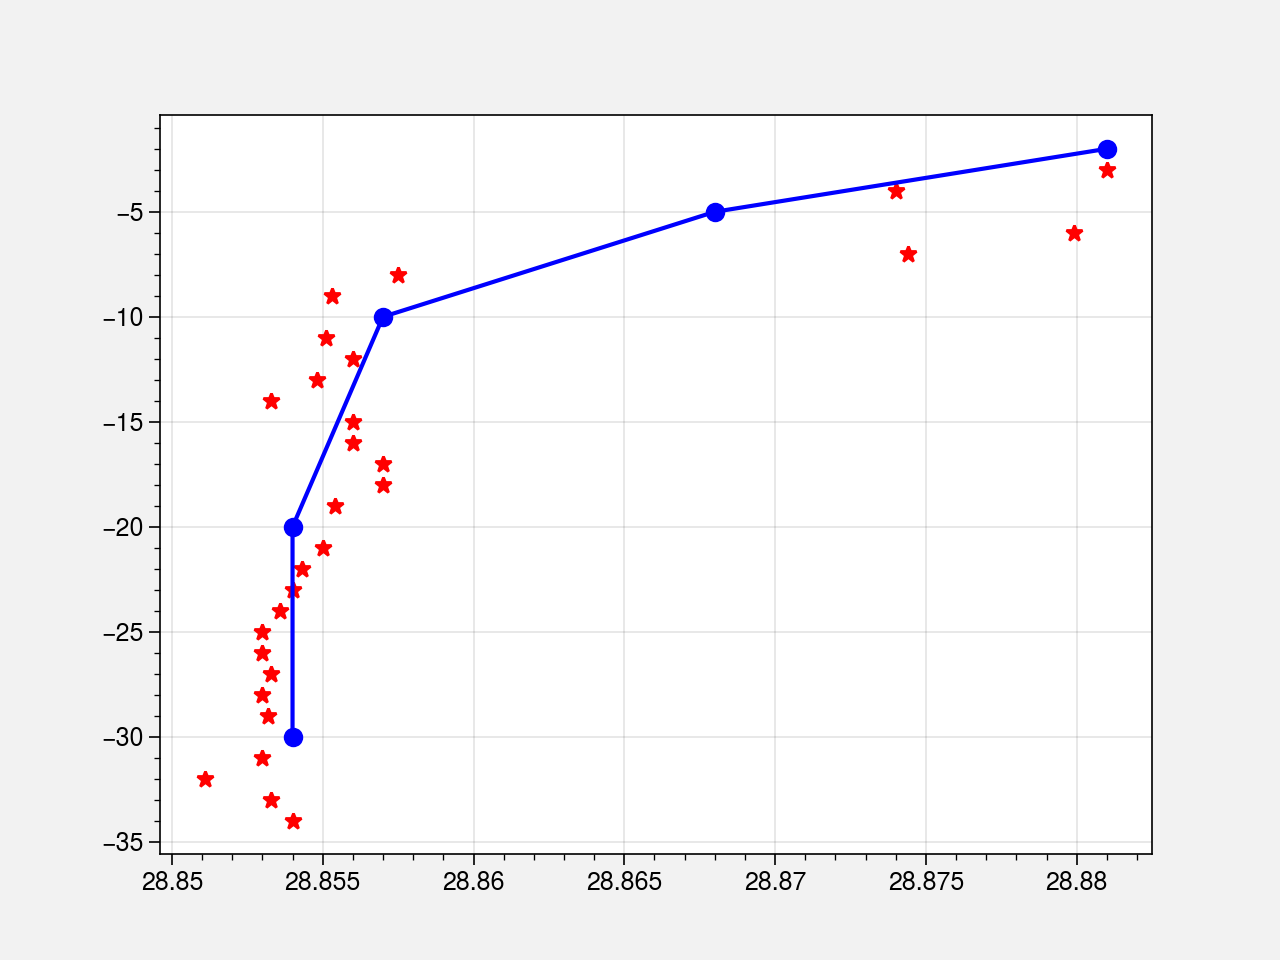

In [31]:
i_cast = 1

plt.plot(data_vars[i_cast,:],-pressure_obs[:,i_cast],'r*')
plt.plot(interp_var_dataarray['Temperature'].isel(cast=i_cast),-interp_var_dataarray['pressure'],'b-o')


In [98]:
z[49,0:20]

<xarray.DataArray 'z' (z_index: 20)>
array([ -2.269781,  -2.960574,  -3.947413,  -4.934242,  -5.921062,  -6.907872,
        -7.894672,  -8.881463,  -9.868244, -10.855017, -11.841779, -12.828532,
       -13.815275, -14.802009, -15.788733, -16.775448, -17.762154, -18.74885 ,
       -19.735535, -20.722212])
Coordinates:
    cast     int64 49
  * z_index  (z_index) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Attributes:
    standard_name:        depth
    long_name:            depth_below_sea_surface
    units:                m
    positive:             down
    ancillary_variables:  z_origflag

In [53]:
data_QC[1,0:10]

<xarray.DataArray 'Temperature_origflag' (z_index: 10)>
array([3., 1., 1., 1., 1., 1., 3., 3., 1., 3.])
Coordinates:
    cast     int64 1
  * z_index  (z_index) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:            sea_water_temperature
    standard_name:        sea_water_temperature
    units:                degree_C
    grid_mapping:         crs
    ancillary_variables:  Temperature_origflag

In [54]:
data_varsQC[1,0:10]

<xarray.DataArray 'Temperature' (z_index: 10)>
array([        nan, 15.28034019, 15.28678799, 15.27925301, 15.27164459,
       15.10549641,         nan,         nan, 15.01896763,         nan])
Coordinates:
    cast     int64 1
  * z_index  (z_index) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:            sea_water_temperature
    standard_name:        sea_water_temperature
    units:                degree_C
    grid_mapping:         crs
    ancillary_variables:  Temperature_origflag

In [92]:
interp_var_dataarray = xarray.DataArray(data_var_interp,dims=['cast','pressure'],
                                                                coords={'cast':profile_dataset_with_data_in_lims['cast'],
                                                                       'pressure':pressure_levels})

In [29]:
data_QC[2,:]

<xarray.DataArray 'Temperature_origflag' (z_index: 4932)>
array([ 1.,  1.,  1., ..., nan, nan, nan])
Coordinates:
    cast     int64 2
  * z_index  (z_index) int64 0 1 2 3 4 5 6 ... 4926 4927 4928 4929 4930 4931
Attributes:
    long_name:            sea_water_temperature
    standard_name:        sea_water_temperature
    units:                degree_C
    grid_mapping:         crs
    ancillary_variables:  Temperature_origflag

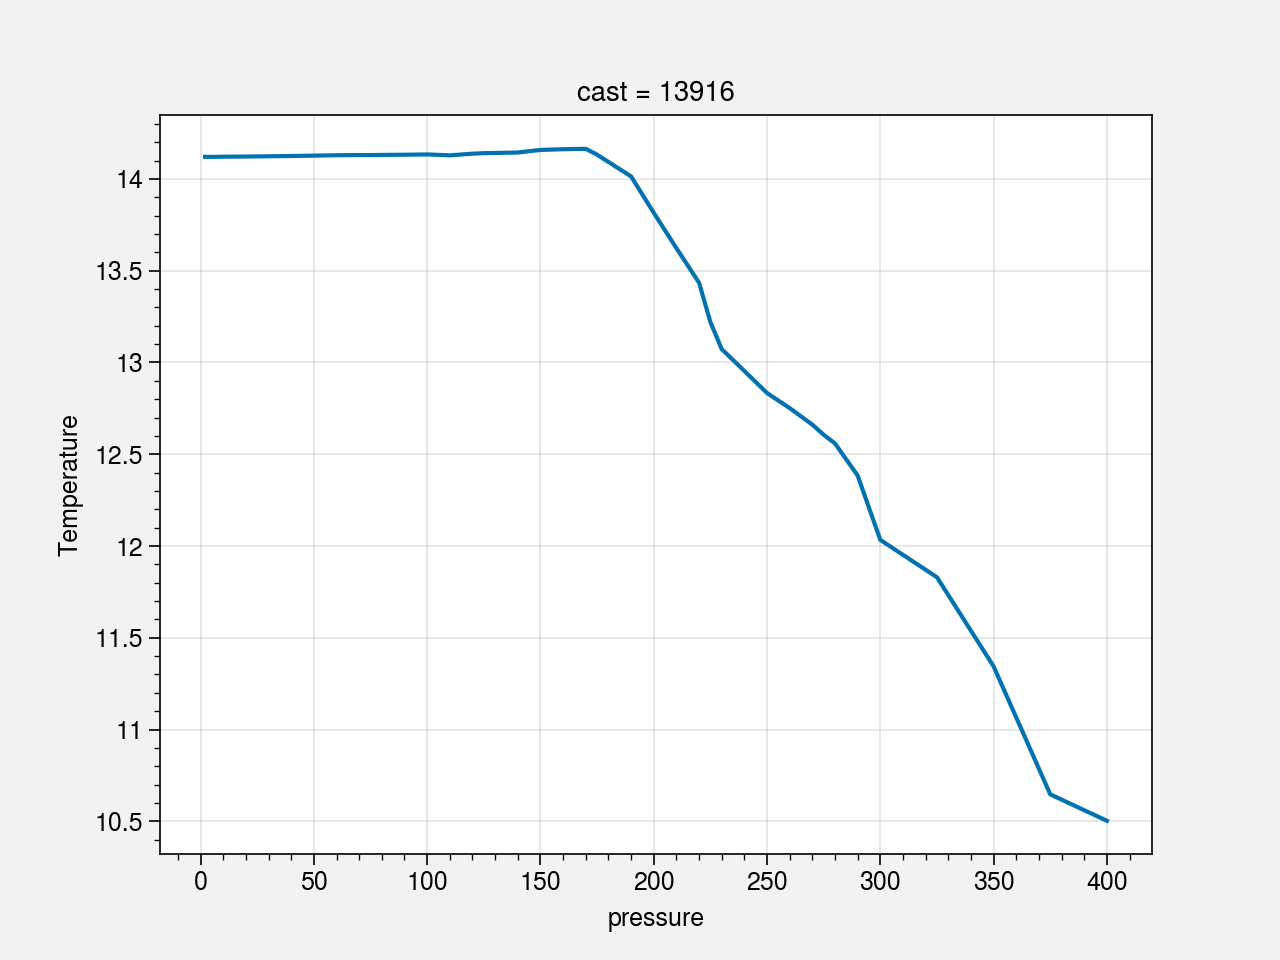

In [12]:
interp_var_dataarray['Temperature'].isel(cast=300).T.plot()

In [15]:
data_var_interp = gsw_tracer_interp(data_vars.values.T, z.values.T, pressure_levels, scale_factor=0.33)



ValueError: not enough values to unpack (expected 2, got 1)

In [141]:
z

<xarray.DataArray 'z' (cast: 1285, z_index: 70)>
array([[-3.976244, -4.970293, -5.964337, ...,       nan,       nan,       nan],
       [-2.982191, -3.976245, -4.970294, ...,       nan,       nan,       nan],
       [-2.982207, -3.976266, -4.970321, ...,       nan,       nan,       nan],
       ...,
       [-1.98789 , -2.981828, -3.975762, ...,       nan,       nan,       nan],
       [-0.993945, -1.987885, -2.98182 , ...,       nan,       nan,       nan],
       [-3.9758  , -4.969738, -5.963671, ...,       nan,       nan,       nan]])
Coordinates:
  * cast     (cast) int64 0 1 2 3 4 5 6 7 ... 1278 1279 1280 1281 1282 1283 1284
  * z_index  (z_index) int64 0 1 2 3 4 5 6 7 8 9 ... 61 62 63 64 65 66 67 68 69
Attributes:
    standard_name:        depth
    long_name:            depth_below_sea_surface
    units:                m
    positive:             down
    ancillary_variables:  z_origflag

In [138]:
data_vars

<xarray.DataArray 'Temperature' (cast: 1285, z_index: 70)>
array([[28.8668  , 28.865999, 28.864201, ...,       nan,       nan,       nan],
       [28.881001, 28.874001, 28.868   , ...,       nan,       nan,       nan],
       [28.9079  , 28.9006  , 28.897301, ...,       nan,       nan,       nan],
       ...,
       [27.962999, 27.966999, 27.971001, ...,       nan,       nan,       nan],
       [28.077   , 28.076   , 28.077   , ...,       nan,       nan,       nan],
       [27.690001, 27.692499, 27.694   , ...,       nan,       nan,       nan]])
Coordinates:
  * cast     (cast) int64 0 1 2 3 4 5 6 7 ... 1278 1279 1280 1281 1282 1283 1284
  * z_index  (z_index) int64 0 1 2 3 4 5 6 7 8 9 ... 61 62 63 64 65 66 67 68 69
Attributes:
    long_name:            sea_water_temperature
    standard_name:        sea_water_temperature
    units:                degree_C
    grid_mapping:         crs
    ancillary_variables:  Temperature_origflag

In [140]:
pressure_obs.shape

(38, 125)

ValueError: x and y must have same first dimension, but have shapes (70,) and (38,)

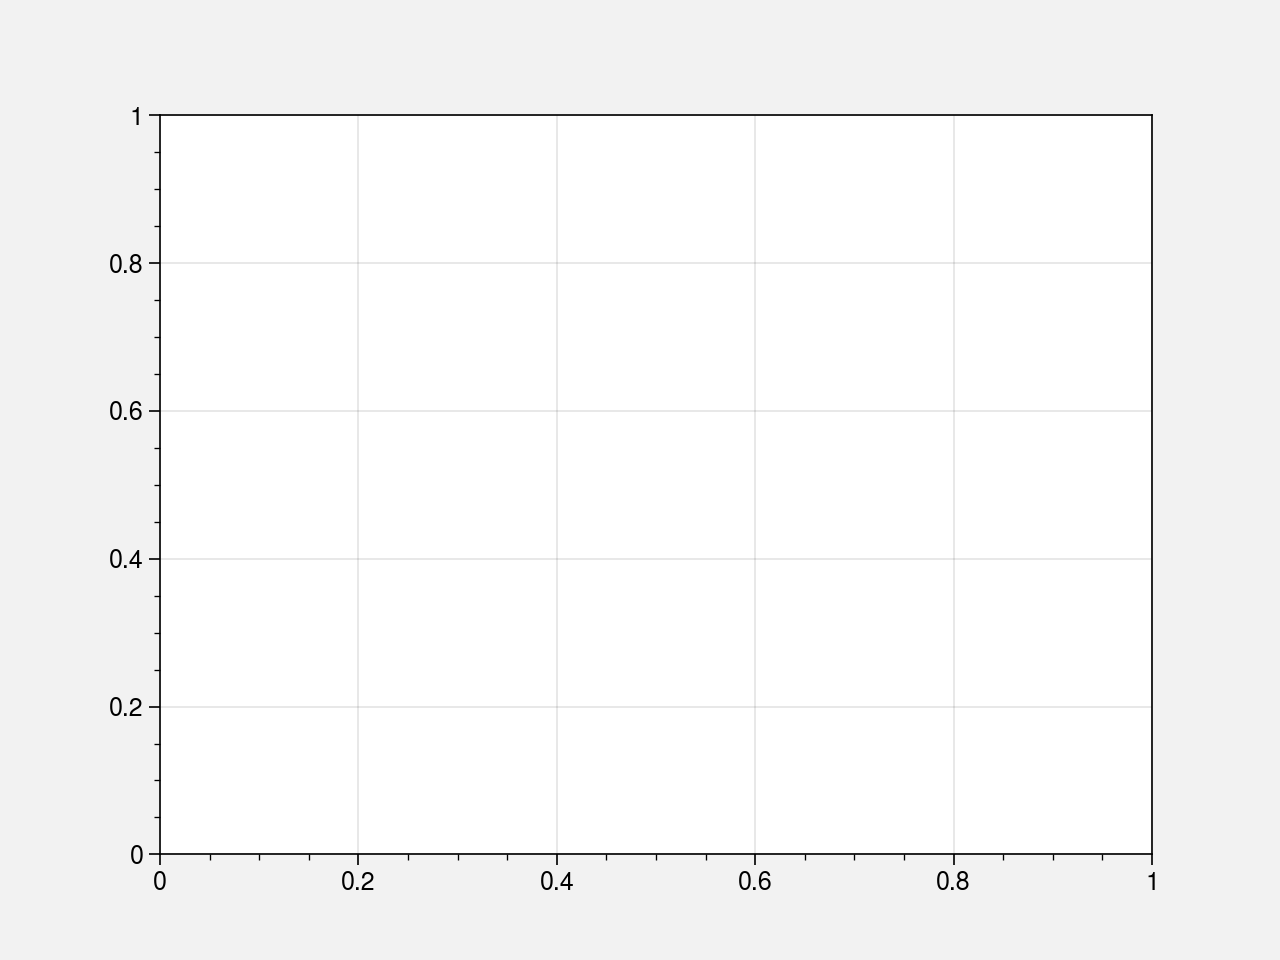

In [135]:
i_cast =40

plt.plot(data_vars[i_cast,:],-pressure_obs[:,i_cast],'r*')
plt.plot(interp_var_dataarray['Temperature'][i_cast,:],-pressure_levels)


In [137]:
pressure_obs.shape

(38, 125)

In [18]:
interp_var_dataarray['Temperature'][i_cast,:]

<xarray.DataArray 'Temperature' (pressure: 80)>
array([15.62443655, 15.62807914, 15.62899971, 15.62899971, 15.62264833,
       15.56713589, 15.4958094 , 15.40267997, 15.11552402, 14.83376164,
       14.19799995, 12.50891181, 12.25458626, 12.01103934, 11.72014872,
       11.60660767, 11.53899956, 11.42924683, 11.25590969, 11.02191366,
       10.87823171, 10.77145493, 10.70300007, 10.5881095 , 10.43468306,
       10.34787734, 10.31048573, 10.33505707, 10.33860444, 10.32600021,
       10.22720412, 10.1710704 , 10.06158798,  9.92000008,  9.91936318,
        9.88846911,  9.83204909,  9.68339164,  9.59027045,  9.4764311 ,
        9.32400036,  9.05565749,  8.97356086,  8.77760394,  8.71960458,
        8.3409996 ,  7.88490353,  7.60900021,  7.23858494,  7.03173254,
        6.71226174,  6.35981753,  6.03599977,  5.76397859,  5.43979931,
        4.98699999,  4.6812128 ,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])
Coordinates:
    cast      int64 99
  * pressure  (pressure) int64 2 5 10 20 30 40 ... 4250 4500 4750 5000 5500 6000

In [19]:
latitude_points  = {}
longitude_points = {}
time_points      = {}


for i_var in DATA_VARIABLES:
    print(i_var)
    latitude_points[i_var]  = {}
    longitude_points[i_var] = {}
    time_points[i_var]      = {}
    for i_year in range(START_YEAR,END_YEAR+1):
    
        latitude_points[i_var][i_year]  = {}
        longitude_points[i_var][i_year] = {}
        time_points[i_var][i_year]      = {}

        for i_platform in OBS_PLATFORM:
            latitude_points[i_var][i_year][i_platform] = {} 
            longitude_points[i_var][i_year][i_platform] = {} 
            time_points[i_var][i_year][i_platform]      = {} 
        
            for i_source in  DATA_SOURCE:
                file_to_get = i_source + '_CODA_' + str(i_year) + '_' + i_platform + '.nc'  #WOD_CODA_2010_pfl_test_all_vars.nc
                if os.path.isfile(os.path.join(CODA_path,str(i_year),file_to_get)):
                    #print ('found:', file_to_get)
                    
                    profile_dataset  = xarray.open_dataset(os.path.join(CODA_path,str(i_year),file_to_get),mask_and_scale=True)
                    
                    if i_var in profile_dataset.data_vars:
                    
                
                        variable_casts  = profile_dataset[i_var]
                        idx_casts_with_data = np.nonzero(np.logical_not(np.all(np.isnan(variable_casts),axis=1)).values)[0]
                        
                        profile_dataset_with_data = profile_dataset.isel(cast=idx_casts_with_data)
                        
                        
                        dsada
                        #print(profile_dataset_with_data['lat'].values)
                        
                        n_casts = profile_dataset_with_data['cast'].size
                        
                        if n_casts != 0:
                            latitude_points[i_var][i_year][i_platform][i_source]  = profile_dataset_with_data['lat'].values
                            longitude_points[i_var][i_year][i_platform][i_source] = profile_dataset_with_data['lon'].values
                            time_points[i_var][i_year][i_platform][i_source]      = pandas.to_datetime(profile_dataset_with_data['time'].values)
                        else:
                            latitude_points[i_var][i_year][i_platform][i_source]  = []
                            longitude_points[i_var][i_year][i_platform][i_source] = []
                            time_points[i_var][i_year][i_platform][i_source]      = []
                            
                            
                        
                    else:
                        longitude_points[i_var][i_year][i_platform][i_source] = []
                        latitude_points[i_var][i_year][i_platform][i_source]  = []
                        time_points[i_var][i_year][i_platform][i_source]      = []

                else:
              
                    longitude_points[i_var][i_year][i_platform][i_source] = []
                    latitude_points[i_var][i_year][i_platform][i_source]  = []
                    time_points[i_var][i_year][i_platform][i_source]      = []    

Temperature


NameError: name 'dsada' is not defined

In [20]:
lat_points = profile_dataset_with_data['lat'].values
lon_points = profile_dataset_with_data['lon'].values



idx_in_lat_lon_lims = np.nonzero(np.logical_and(np.logical_and(lat_points>=SOUTH_LAT_LIM,lat_points<=NORTH_LAT_LIM ) ,
                                                np.logical_and(lon_points>=WEST_LON_LIM,lon_points<=EAST_LON_LIM ) ) )[0]

lat_points_in_lat_lon_lims = profile_dataset_with_data['lat'].isel(cast=idx_in_lat_lon_lims)
lon_points_in_lat_lon_lims = profile_dataset_with_data['lon'].isel(cast=idx_in_lat_lon_lims)


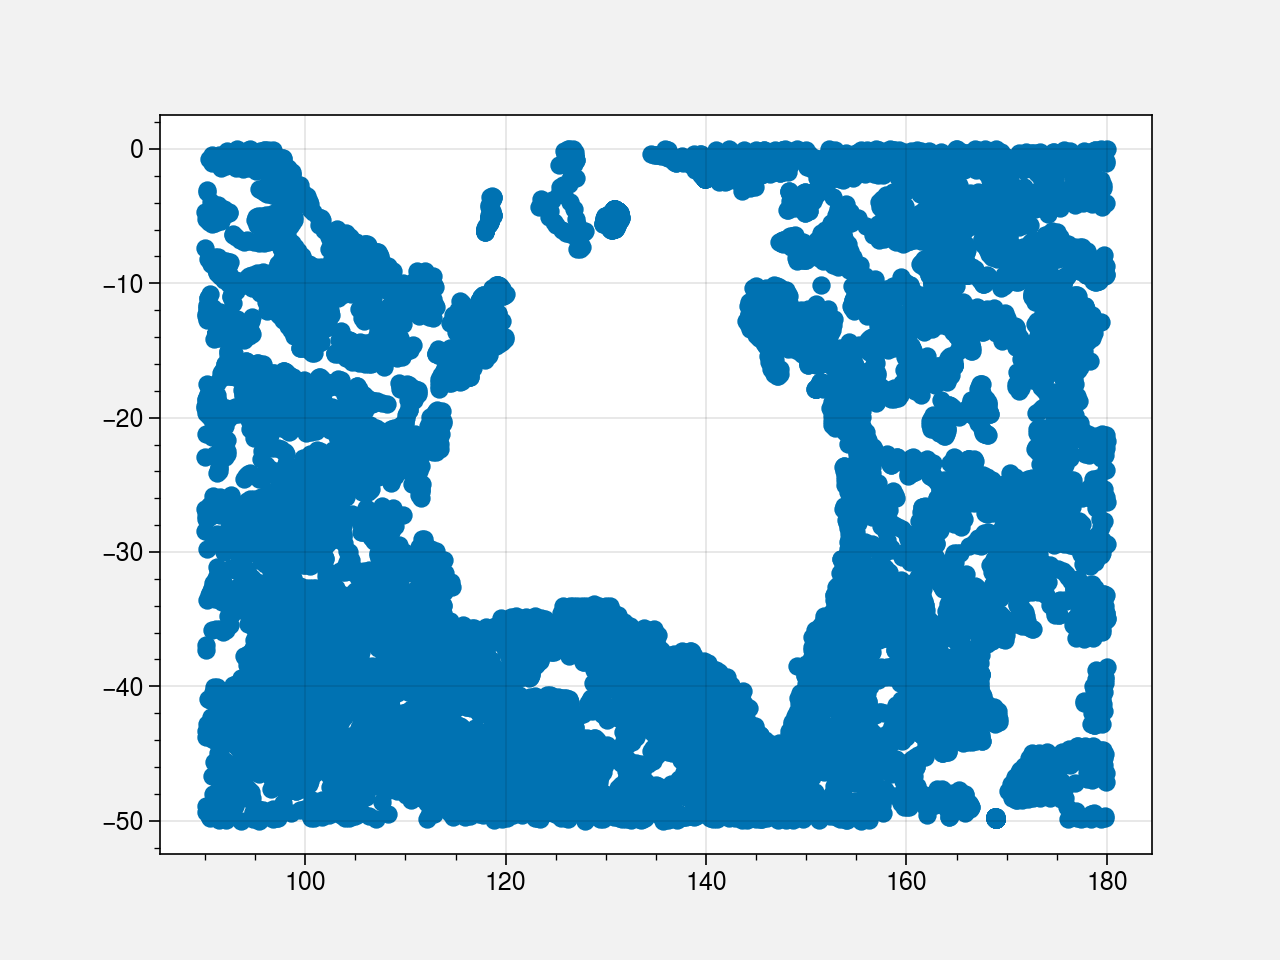

In [21]:
plt.scatter(lon_points_in_lat_lon_lims,lat_points_in_lat_lon_lims)